In [16]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

import scipy.sparse as sparse

%matplotlib inline

from implicit.als import AlternatingLeastSquares

In [17]:
raw_data = pd.read_csv('tmpdata/usersha1-artmbid-artname-plays.tsv', sep='\t')

In [18]:
raw_data = raw_data.drop(raw_data.columns[1], axis=1)
raw_data.columns = ['user', 'artist', 'plays']

In [19]:
raw_data.head()

user                 artist  plays
0  00000c289a1829a808ac09c00daf10bc3c4e223b              die Ärzte   1099
1  00000c289a1829a808ac09c00daf10bc3c4e223b      melissa etheridge    897
2  00000c289a1829a808ac09c00daf10bc3c4e223b              elvenking    717
3  00000c289a1829a808ac09c00daf10bc3c4e223b   juliette & the licks    706
4  00000c289a1829a808ac09c00daf10bc3c4e223b  red hot chili peppers    691

In [20]:
data = raw_data.dropna()

In [21]:
data.loc[[1,2]]

user             artist  plays
1  00000c289a1829a808ac09c00daf10bc3c4e223b  melissa etheridge    897
2  00000c289a1829a808ac09c00daf10bc3c4e223b          elvenking    717

In [22]:
len(np.where(data.plays < 2000)[0])

17379088

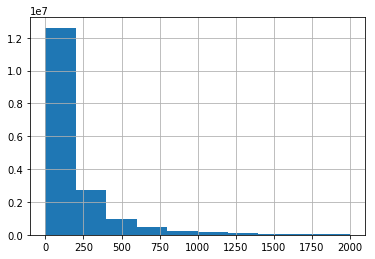

In [23]:
data.iloc[np.where(data.plays < 2000)].plays.hist()

In [24]:
data['user_id'] = data['user'].astype("category").cat.codes
data['artist_id'] = data['artist'].astype("category").cat.codes

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [25]:
data.head()

user                 artist  plays  \
0  00000c289a1829a808ac09c00daf10bc3c4e223b              die Ärzte   1099   
1  00000c289a1829a808ac09c00daf10bc3c4e223b      melissa etheridge    897   
2  00000c289a1829a808ac09c00daf10bc3c4e223b              elvenking    717   
3  00000c289a1829a808ac09c00daf10bc3c4e223b   juliette & the licks    706   
4  00000c289a1829a808ac09c00daf10bc3c4e223b  red hot chili peppers    691   

   user_id  artist_id  
0        0      90933  
1        0     185367  
2        0     106704  
3        0     155241  
4        0     220128

In [26]:
item_lookup = data[['artist_id', 'artist']].drop_duplicates()
item_lookup['artist_id'] = item_lookup.artist_id.astype(str)

In [27]:
item_lookup.head()

artist_id                 artist
0     90933              die Ärzte
1    185367      melissa etheridge
2    106704              elvenking
3    155241   juliette & the licks
4    220128  red hot chili peppers

In [28]:
artist_id_name = {}

for index, row in tqdm_notebook(item_lookup.iterrows()):
    artist_id_name[row.artist_id] = row.artist

In [29]:
data = data.drop(['user', 'artist'], axis=1)

In [30]:
data.head()

plays  user_id  artist_id
0   1099        0      90933
1    897        0     185367
2    717        0     106704
3    706        0     155241
4    691        0     220128

In [31]:
data.count()

plays        17535450
user_id      17535450
artist_id    17535450
dtype: int64

In [32]:
data = data.loc[data.plays != 0]

In [33]:
data.head()

plays  user_id  artist_id
0   1099        0      90933
1    897        0     185367
2    717        0     106704
3    706        0     155241
4    691        0     220128

In [34]:
users = list(np.sort(data.user_id.unique()))
artists = list(np.sort(data.artist_id.unique()))
plays = list(data.plays)

In [35]:
users[:5]

[0, 1, 2, 3, 4]

In [36]:
artists[:5]

[0, 1, 2, 3, 4]

In [37]:
plays[:5]

[1099, 897, 717, 706, 691]

In [38]:
data.loc[(data['user_id'] == 0)]

plays  user_id  artist_id
0    1099        0      90933
1     897        0     185367
2     717        0     106704
3     706        0     155241
4     691        0     220128
5     545        0     177597
6     507        0     252797
7     424        0     259856
8     403        0     175802
9     393        0     278311
10    387        0     169906
11    361        0     126690
12    358        0     137062
13    329        0     253488
14    316        0     144293
15    310        0      37515
16    302        0     100639
17    288        0      19592
18    281        0     167984
19    244        0     230100
20    232        0     103711
21    231        0     184079
22    229        0      19356
23    227        0     144238
24    222        0     106689
25    220        0     219078
26    210        0     172574
27    208        0     258212
28    205        0     194518
29    198        0     154684
30    198        0     223386
31    189        0     253139
32    185        0      51085
33    183        0     228759
34    182        0     151766
35    175        0     237283
36    168        0     264743
37    154        0      92172
38    153        0     249370
39    151        0     129383
40    150        0     261945
41    145        0     171686
42    137        0     249971
43    135        0      45554
44    135        0     165120
45    134        0      46244
46    134        0     125484
47    131        0     264544

In [39]:
len(users)

358868

In [40]:
len(artists)

292363

In [48]:
print(len(artists), len(users))

292363 358868


In [49]:
rows = data.user_id.astype(int)
cols = data.artist_id.astype(int)

In [50]:
print(len(rows), len(cols), len(plays))

17535449 17535449 17535449


In [51]:
data_sparse = sparse.csr_matrix((plays, (cols, rows)), shape=(len(artists), len(users)))

In [75]:
data_sparse

<292363x358868 sparse matrix of type '<class 'numpy.int32'>'
	with 17535374 stored elements in Compressed Sparse Row format>

In [76]:
model = AlternatingLeastSquares(factors=50)
model.fit(data_sparse)

100%|██████████| 15.0/15 [00:48<00:00,  4.15s/it]


In [77]:
userid = 0

user_items = data_sparse.T.tocsr()
recommendations = model.recommend(userid, user_items)

In [78]:
recommendations

[(161833, 1.4009811),
 (116811, 1.282584),
 (255208, 1.2036607),
 (205613, 1.1877083),
 (146193, 1.1746488),
 (140813, 1.1554971),
 (128172, 1.1399059),
 (155242, 1.1392939),
 (199842, 1.1367174),
 (12523, 1.1235025)]

In [79]:
for r in recommendations:
    print(artist_id_name[str(r[0])])

kittie
flyleaf
the dresden dolls
otep
janis joplin
in this moment
green day
juliette and the licks
nirvana
after forever


In [80]:
itemid = 107209
related = model.similar_items(itemid)

In [81]:
related

[(107209, 0.10724083),
 (157178, 0.09309483),
 (3845, 0.091891244),
 (187011, 0.09163401),
 (48904, 0.08900913),
 (155893, 0.08811443),
 (266939, 0.087128006),
 (171169, 0.086488396),
 (127227, 0.08566105),
 (205889, 0.085297294)]

In [82]:
for a in related:
    print(artist_id_name[str(a[0])])

eminem
kanye west
50 cent
michael jackson
black eyed peas
justin timberlake
timbaland
linkin park
gorillaz
outkast


In [83]:
artist_id_name['234786']

'sick on the bus'